In [1]:
from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input
import pandas as pd
import numpy as np
import os

import IPython.display as display

# from PIL import Image

import tensorflow as tf

import tensorflow.keras as keras
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D, Flatten, GlobalMaxPooling2D

from tensorflow.keras.preprocessing import image

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices("GPU")
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
        
def append_extension(fn):
    return (fn+".jpg").zfill(7)

DATADIR = r"./adult" 
CSV_PATH = r"./adult/CastControls_ALP.xlsx"
response = pd.read_excel(
    CSV_PATH,
    sheet_name=0,
)[["GreenID", "Grade"]].dropna(axis=0, subset=['Grade'])
response.Grade = response.Grade.astype('int')
response.GreenID = response.GreenID.astype('str').apply(append_extension)
response = response[response.Grade != 99]

data_gen = ImageDataGenerator(
    rotation_range=5,
    fill_mode='reflect',
    horizontal_flip=True,
#     vertical_flip=True,
    validation_split=0.1,
    rescale=1. / 255.,
#     preprocessing_function = preprocess_input
    zoom_range = 0.1
)

train_set = data_gen.flow_from_dataframe(
    dataframe=response,
    directory=DATADIR,
    x_col="GreenID",
    y_col="Grade",
    target_size=(224,224),
    color_mode='rgb',
    class_mode='raw',
    subset = "training",
    shuffle=True,
#     class_mode = "sparse"
)

validation_set = data_gen.flow_from_dataframe(
    dataframe=response,
    directory=DATADIR,
    x_col="GreenID",
    y_col="Grade",
    target_size=(224,224),
    color_mode='rgb',
    class_mode='raw',
    subset = "validation",
    shuffle=True,
#     class_mode = "sparse"
)

base_model = DenseNet121(include_top=False, weights="imagenet", classes=5, input_shape=(224,224,3))

# rounded accuracy
import tensorflow.keras.backend as K
def soft_acc(y_true, y_pred):
    return K.mean(K.equal(K.round(y_true), K.round(y_pred)))

1 Physical GPUs, 1 Logical GPUs
Found 507 validated image filenames.
Found 56 validated image filenames.


C:\Users\feroc\Anaconda3\envs\tf\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 6 invalid image filename(s) in x_col="GreenID". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [2]:
base_model.trainable = True

for layer in base_model.layers[:70]:
    layer.trainable = False
# else:
#     layer.trainable = True

x = base_model.output

# x = Conv2D(64, (3, 3), strides = 1, activation="linear", kernel_initializer='he_uniform', )(x)
# x = Flatten()(x)

x = GlobalAveragePooling2D()(x)
# x = Dense(256, activation="sigmoid",bias_initializer = tf.keras.initializers.Constant(value=0))(x)
preds = Dense(1, activation="linear", bias_initializer = tf.keras.initializers.Constant(value=4),
#               kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.01, l2=0.01),
             bias_constraint = tf.keras.constraints.MinMaxNorm(min_value=2, max_value=6, rate=1.0, axis=0),
             )(x)
model = Model(inputs=base_model.input, outputs=preds)

model.compile(optimizer=keras.optimizers.Nadam(), loss='mse', metrics=["mse", soft_acc])
callback = tf.keras.callbacks.EarlyStopping(monitor='val_mse', patience=3)
model.fit_generator(generator=train_set,
                    epochs=300,
#                     verbose=2,
                    validation_data=validation_set,
#                     validation_freq=2,
                    )

Epoch 1/300
16/16 [==============================] - 14s 881ms/step - loss: 2.3794 - mse: 2.3854 - soft_acc: 0.2763 - val_loss: 0.8941 - val_mse: 0.9018 - val_soft_acc: 0.3438
Epoch 2/300
16/16 [==============================] - 11s 705ms/step - loss: 0.9581 - mse: 0.9573 - soft_acc: 0.3626 - val_loss: 1.8970 - val_mse: 1.8756 - val_soft_acc: 0.3021
Epoch 3/300
16/16 [==============================] - 11s 700ms/step - loss: 0.7036 - mse: 0.7062 - soft_acc: 0.4518 - val_loss: 2.0063 - val_mse: 2.0550 - val_soft_acc: 0.2552
Epoch 4/300
16/16 [==============================] - 11s 695ms/step - loss: 0.5005 - mse: 0.5012 - soft_acc: 0.5234 - val_loss: 0.9917 - val_mse: 1.0019 - val_soft_acc: 0.3333
Epoch 5/300
16/16 [==============================] - 11s 694ms/step - loss: 0.5307 - mse: 0.5330 - soft_acc: 0.5136 - val_loss: 1.2299 - val_mse: 1.1491 - val_soft_acc: 0.3281
Epoch 6/300
16/16 [==============================] - 11s 713ms/step - loss: 0.4251 - mse: 0.4262 - soft_acc: 0.5461 - va

KeyboardInterrupt: 

In [ ]:
# hinge loss doesnt work

In [ ]:
model.summary()

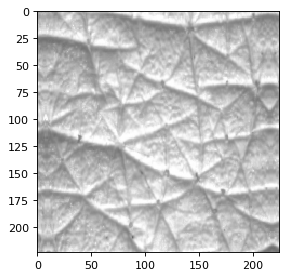

true label: 3; rounded pred: [[2.986268]]


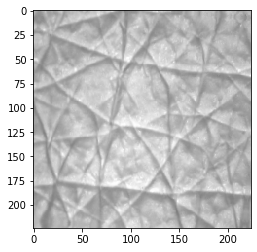

true label: 4; rounded pred: [[3.1750808]]


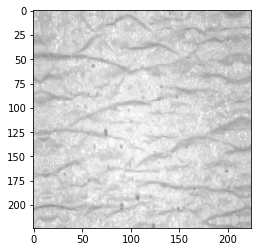

true label: 5; rounded pred: [[4.884676]]


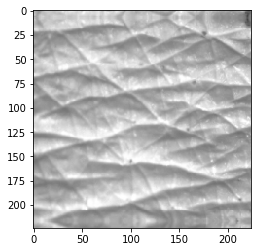

true label: 5; rounded pred: [[3.6473756]]


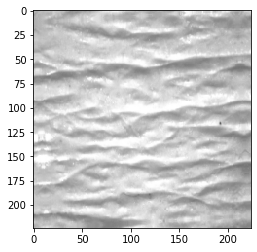

true label: 6; rounded pred: [[4.974026]]


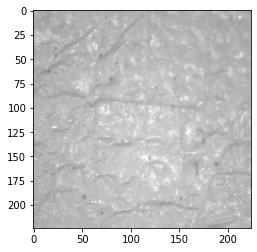

true label: 6; rounded pred: [[5.6543207]]


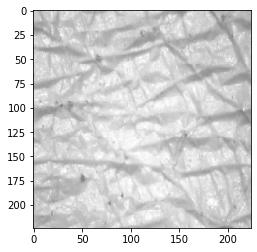

true label: 4; rounded pred: [[4.167931]]


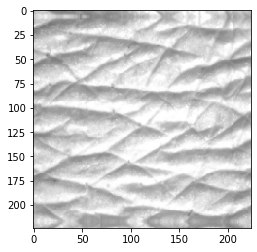

true label: 3; rounded pred: [[3.6477313]]


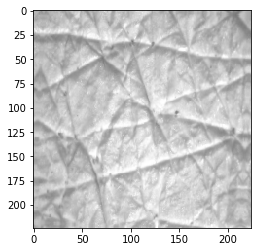

true label: 3; rounded pred: [[3.863393]]


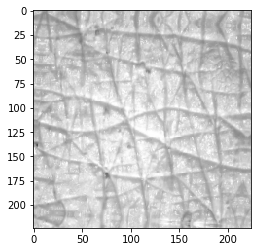

true label: 3; rounded pred: [[3.1440191]]


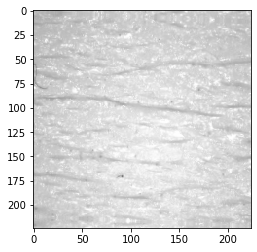

true label: 6; rounded pred: [[5.333065]]


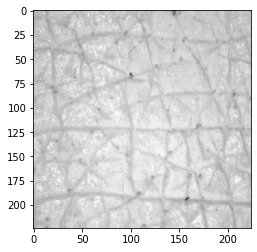

true label: 3; rounded pred: [[4.1397185]]


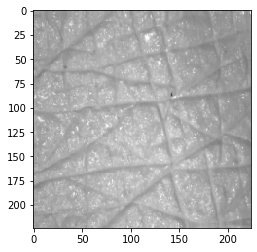

true label: 4; rounded pred: [[4.0233254]]


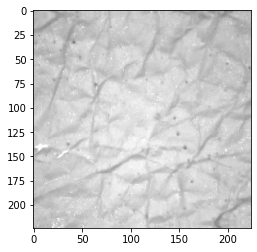

true label: 6; rounded pred: [[5.173997]]


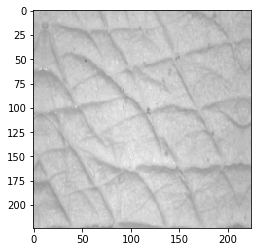

true label: 3; rounded pred: [[3.2370436]]


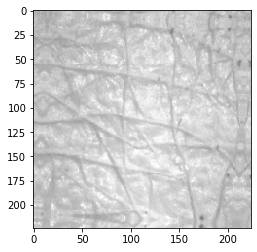

true label: 5; rounded pred: [[4.063559]]


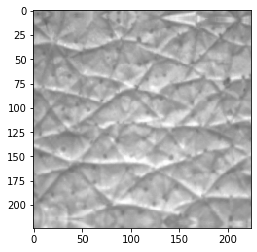

true label: 4; rounded pred: [[4.0056505]]


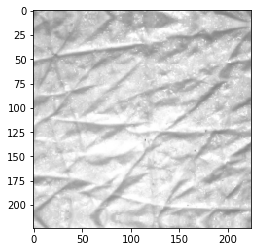

true label: 4; rounded pred: [[4.630087]]


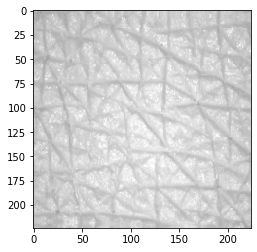

true label: 2; rounded pred: [[3.5529761]]


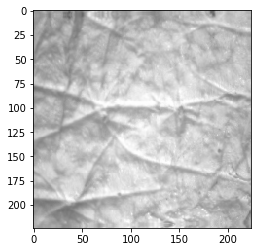

true label: 6; rounded pred: [[4.406539]]


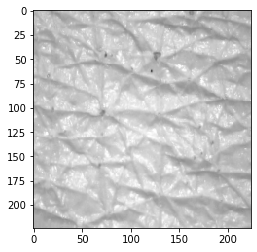

true label: 4; rounded pred: [[4.032382]]


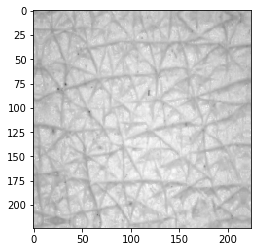

true label: 2; rounded pred: [[3.112296]]


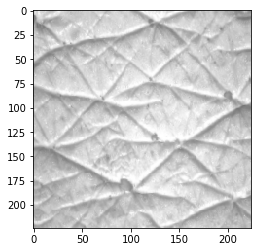

true label: 4; rounded pred: [[3.4178047]]


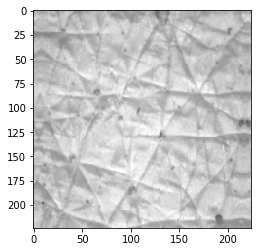

true label: 5; rounded pred: [[4.5593266]]


In [8]:
fig, ax = plt.subplots(dpi=80)
batch = next(validation_set)

# print examples from the validation set
for i in range(len(batch[1])):
    img = batch[0][i]
    label = batch[1][i]
    plt.imshow(img)
    plt.show()
    print(f"true label: {label}; rounded pred: {model.predict(img.reshape(-1,224, 224, 3))}")